In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
from jax import numpy as jnp
from functools import partial
import optax
import matplotlib.pyplot as plt
import optuna

import plotting
import sim

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
study = optuna.load_study(
    study_name="mango",
    storage="sqlite:///mango4x4.db"
)
study.best_params

{'lr': 0.00023578701760434184,
 'annealing_0': 0.10099114179161942,
 'annealing_1': 0.3309730934805988}

In [16]:
seed = 0
map_size = 4
max_interactions = 100_000
map_scale = int(jnp.log2(map_size))

# hyperparams
lr = study.best_params["lr"]
rollout_length = 2 * map_size**2
n_rollouts = max_interactions // rollout_length
train_iter = 8

# setup annealing schedules
annealing_durations = [
    int(train_iter * n_rollouts * study.best_params[f"annealing_{i}"]) for i in range(map_scale)
]
annealing_starts = jnp.cumsum(jnp.array([0] + annealing_durations[:-1]))
annealing_schedules = [
    optax.linear_schedule(1.0, 0.01, dur, start)
    for dur, start in zip(annealing_durations, annealing_starts)
]

@jax.jit
def annealing_fn(step):
    return jnp.array([schedule(step) for schedule in annealing_schedules])

In [17]:
run_simulation = partial(
    sim.run_mango_simulation,
    map_size=map_size,
    n_rollouts=n_rollouts,
    rollout_length=rollout_length,
    train_iter=train_iter,
    lr=lr,
    annealing_fn=annealing_fn,
)
rng_key = jax.random.PRNGKey(seed)
env, dql_state, results = jax.vmap(run_simulation)(jax.random.split(rng_key, 8))

  0%|          | 0/3125 [00:00<?, ?it/s]

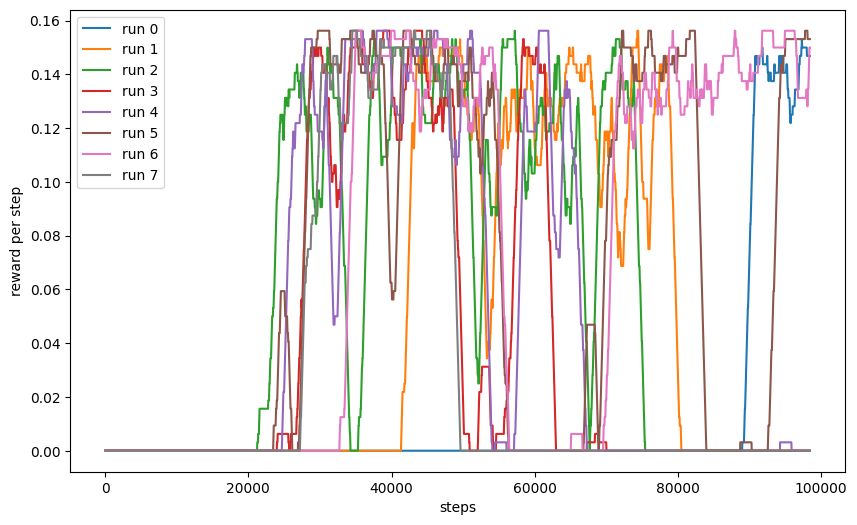

In [18]:
def smooth(r, w=50):
    filter = jnp.ones(w) / w
    return jnp.convolve(r, filter, mode="valid")

outer_eval_rewards = results.eval_reward[:,:,:,0,-1]
outer_expl_rewards = results.expl_reward[:,:,:,0,-1]
plt.figure(figsize=(10, 6))
for i, (r, n) in enumerate(zip(outer_eval_rewards.sum(axis=-1), results.eval_done.sum(axis=-1))):
    r = smooth(r) / outer_eval_rewards.shape[-1]
    plt.plot(outer_eval_rewards.shape[-1]*jnp.arange(1,1+len(r)), r, label=f"run {i}")
# for i, (r, n) in enumerate(zip(outer_expl_rewards.sum(axis=-1), results.expl_done.sum(axis=-1))):
#     r = smooth(r) / outer_expl_rewards.shape[-1]
#     plt.plot(outer_expl_rewards.shape[-1]*jnp.arange(1,1+len(r)), r, alpha=0.5)
plt.ylabel("reward per step")
plt.xlabel(f"steps")
plt.legend()
plt.show()

In [19]:
import mango_utils
batch_rollout = jax.vmap(partial(mango_utils.eps_greedy_rollout, rng_key=rng_key, epsilons=jnp.zeros(2), steps=128))
batch_qvals = lambda params, obs: jax.vmap(dql_state.qval_apply_fn, in_axes=(0,None))(params, obs).mean(axis=0)

transitions = batch_rollout(env, dql_state)
outer_eval_rewards = transitions.rewards[:,:,0,-1]
for tot_reward, n_episodes in zip(outer_eval_rewards.sum(axis=-1), transitions.done.sum(axis=-1)):
    print(f"{int(100*tot_reward/n_episodes)}% success" if n_episodes > 0 else "No success")

100% success
No success
No success
No success
No success
100% success
100% success
No success


In [3]:
seed = 0
map_size = 4
max_interactions = 100_000
map_scale = int(jnp.log2(map_size))

# hyperparams
lr = 1e-3
rollout_length = 2 * map_size**2
n_rollouts = max_interactions // rollout_length
train_iter = 8

# setup annealing schedules
@jax.jit
def annealing_fn(step):
    return jnp.array([1.,1.])

In [4]:
rng_key = jax.random.PRNGKey(0)
run_simulation = partial(
    sim.run_mango_simulation,
    map_size=map_size,
    n_rollouts=n_rollouts,
    rollout_length=rollout_length,
    train_iter=train_iter,
    lr=lr,
    annealing_fn=annealing_fn,
)
env, dql_state, results = run_simulation(rng_key)

  0%|          | 0/3125 [00:00<?, ?it/s]

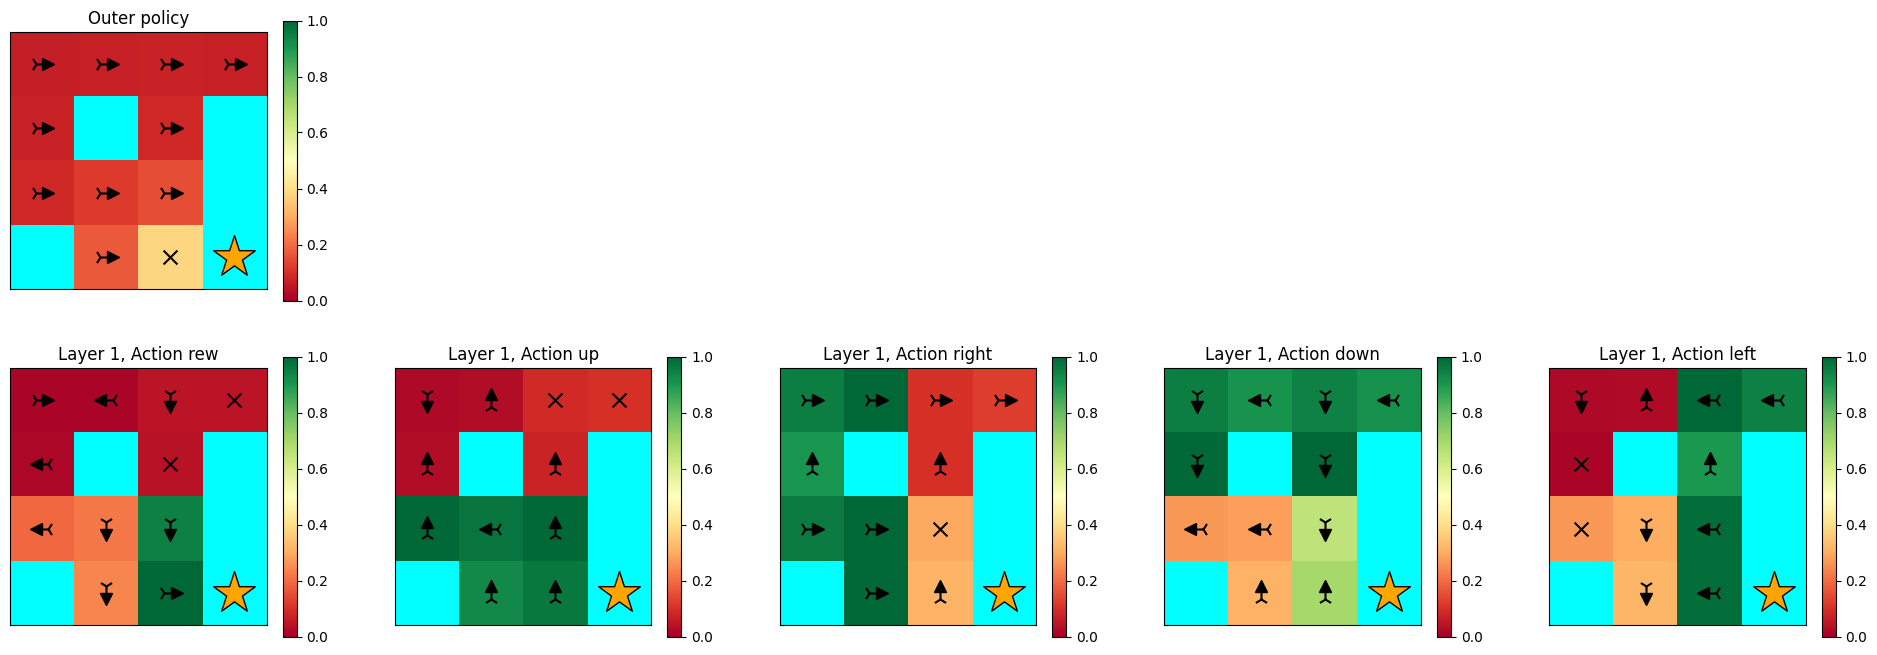

NameError: name 'mango_utils' is not defined

In [5]:
n_actions, n_layers = 5, 2
plt.figure(figsize=((n_actions + 1) * map_size, n_layers * map_size))
for i in range(n_layers):
    if i == 0:
        plt.subplot(n_layers, n_actions, 1)
        plt.title(f'Outer policy')
        apply = lambda params, obs: dql_state.qval_apply_fn(
            params, jnp.repeat(obs[jnp.newaxis], n_layers, axis=0)
        )[i, -1]
        plotting.plot_qvals(env, apply, dql_state.params_qnet, hold=True, autoscale=False)
        continue
    for j in range(5):
        plt.subplot(n_layers, n_actions, i * n_actions + j + 1)
        plt.title(f'Layer {n_layers-i}, Action {["rew","up","right","down","left"][j]}')
        apply = lambda params, obs: dql_state.qval_apply_fn(
            params, jnp.repeat(obs[jnp.newaxis], n_layers, axis=0)
        )[i, 4 - j]
        plotting.plot_qvals(env, apply, dql_state.params_qnet, hold=True, autoscale=False)
plt.show()

transitions = mango_utils.eps_greedy_rollout(env, dql_state, rng_key, jnp.zeros(n_layers), rollout_length)
plotting.render(env, transitions.env_state)